We will import pandas for data storage and analysis.
Import datetime and dateutil for filtering data time range
Use talib to get measures sure as moving averages. 
Use mplfinance and matplotlib to plot stock price and indicators

In [1]:
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import talib
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.pylab import date2num

Since we are using the link to get data on a stock, we need to define the to and from date we need the data from. 
To do that get todays date as a UTC timesstamp using datetime.  

Get ten years ago date in the same format too by using relativedelta where you can specify the exact number of years you want to go back from current date.   

In [2]:
# Get today's date as UTC timestamp
today = datetime.today().strftime("%d/%m/%Y")
today = datetime.strptime(today + " +0000", "%d/%m/%Y %z")
to = int(today.timestamp())
# Get date ten years ago as UTC timestamp
ten_yr_ago = today-relativedelta(years=10)
fro = int(ten_yr_ago.timestamp())

Use the yfinance url to get data for a set stock(ticker) and to and from dates. We then create a database using pandas and index it using the dates coloumn. You can then call the function for any stock you want information on. In this case they used Netflix(Nflx

In [3]:
def get_price_hist(ticker):

    # Put stock price data in dataframe
    url = "https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={fro}&period2={to}&interval=1d&events=history".format(ticker=ticker, fro=fro, to=to)
    data = pd.read_csv(url)
    
    # Convert date to timestamp and make index
    data.index = data["Date"].apply(lambda x: pd.Timestamp(x))
    data.drop("Date", axis=1, inplace=True)

    return data
nflx_df = get_price_hist("NFLX")
nflx_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-02-28,30.549999,30.615713,29.000000,29.524286,29.524286,40524400
2011-03-01,29.457144,29.637142,28.678572,29.232857,29.232857,39839100
2011-03-02,29.285713,29.642857,28.821428,29.175714,29.175714,33028800
2011-03-03,29.500000,29.584286,28.621429,29.052856,29.052856,35263200
2011-03-04,29.107143,30.182858,29.107143,30.102858,30.102858,44178400
...,...,...,...,...,...,...
2021-02-19,548.000000,548.989990,538.809998,540.219971,540.219971,2838600
2021-02-22,534.989990,541.789978,530.789978,533.780029,533.780029,3076900
2021-02-23,525.000000,548.539978,518.280029,546.150024,546.150024,4133500


Next, we will get indicators such as MACD, simple moving average and RSI. 
When using Talib, it automatically gets the MACd, its signal( the 9day exponetial moving average) 
and a coloumn which helps plot a histogram showing the difference between MACD and its signal. 
Using talib, you can calculate any indicators by calling their functions. such as talib.MA()

In [4]:
def get_indicators(data):
    # Get MACD
    data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['Close'])
    
    # Get MA10 and MA30
    data["ma10"] = talib.MA(data["Close"], timeperiod=10)
    data["ma30"] = talib.MA(data["Close"], timeperiod=30)
    
    # Get RSI
    data["rsi"] = talib.RSI(data["Close"])
    return data

Once we have our historical data on the Netflix stock and all the indicators, we can plot them using matplotlib and mpl finance. 

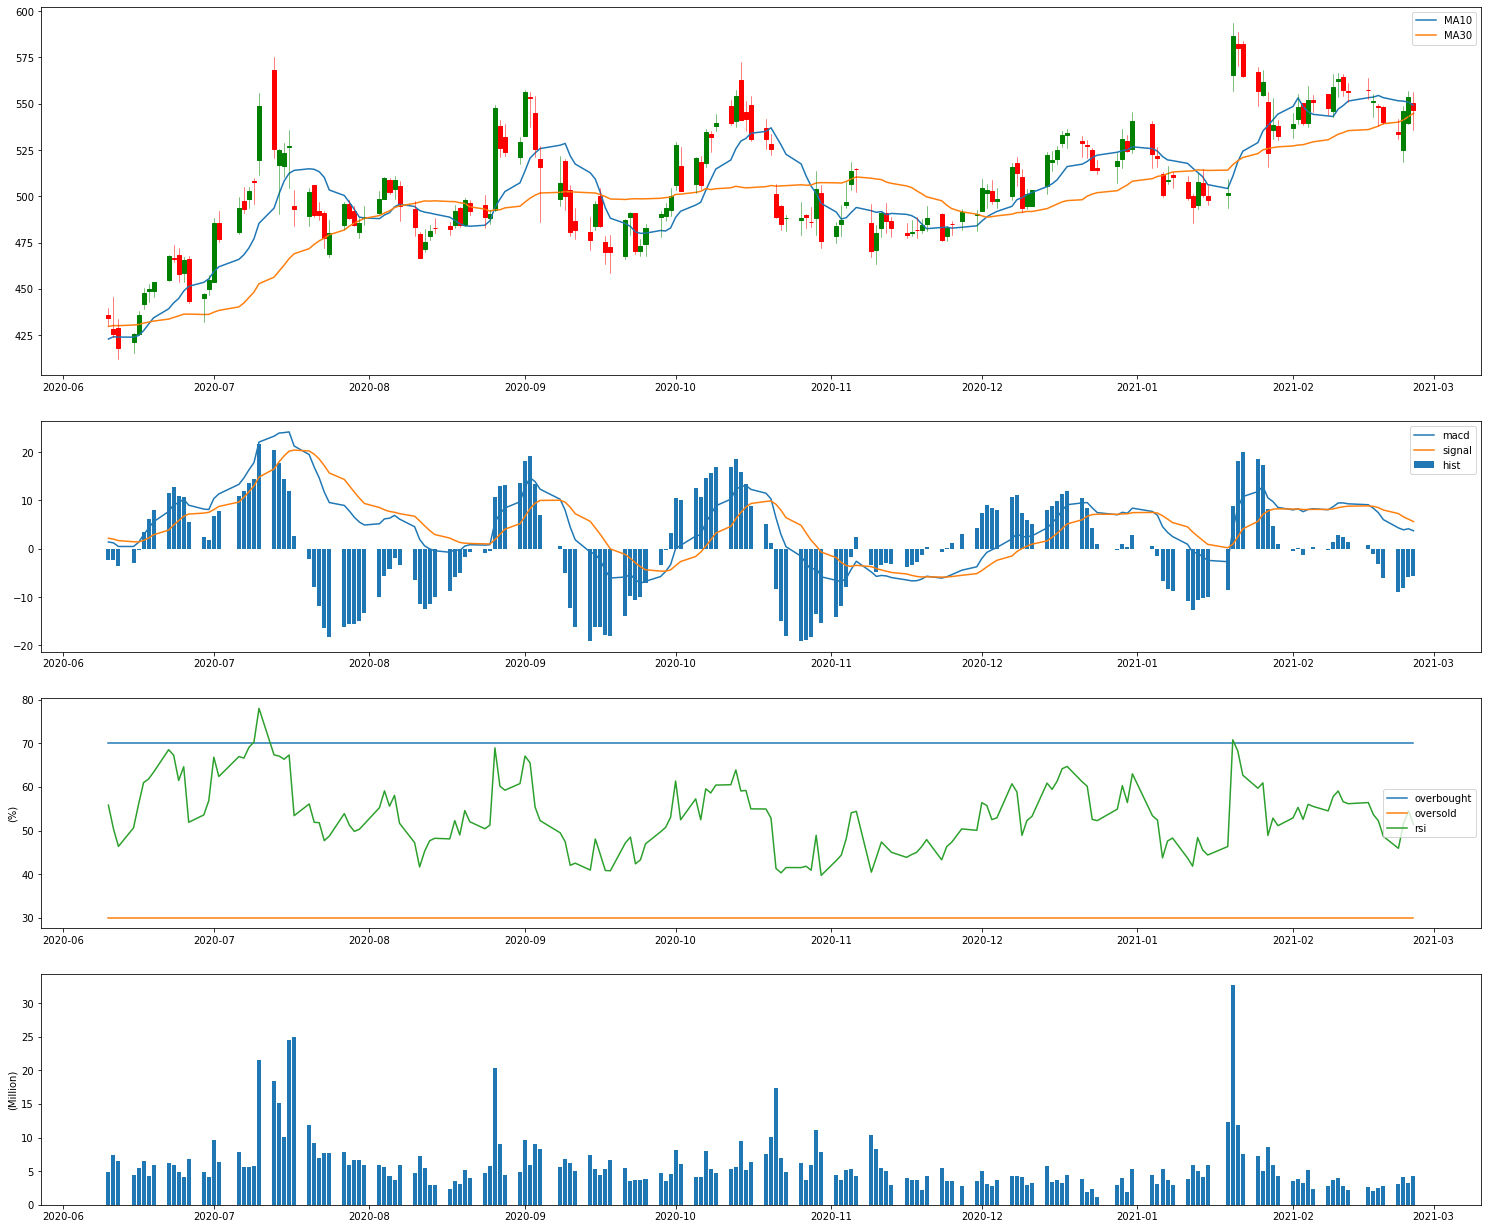

In [6]:
nflx_df2 = get_indicators(nflx_df)
nflx_df2

def plot_chart(data, n, ticker):
    
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20, 16))
    ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
    ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_rsi = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    # Plot candlestick chart
    ax_candle.plot(data.index, data["ma10"], label="MA10")
    ax_candle.plot(data.index, data["ma30"], label="MA30")
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
    ax_candle.legend()
    
    # Plot MACD
    ax_macd.plot(data.index, data["macd"], label="macd")
    ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
    ax_macd.plot(data.index, data["macd_signal"], label="signal")
    ax_macd.legend()
    
    # Plot RSI
    # Above 70% = overbought, below 30% = oversold
    ax_rsi.set_ylabel("(%)")
    ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
    ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
    ax_rsi.plot(data.index, data["rsi"], label="rsi")
    ax_rsi.legend()
    
    # Show volume in millions
    ax_vol.bar(data.index, data["Volume"] / 1000000)
    ax_vol.set_ylabel("(Million)")
   
    # Save the chart as PNG
    #fig.savefig("charts/" + ticker + ".png", bbox_inches="tight")
    
    plt.show()

plot_chart(nflx_df2, 180, "NFLX")